# Tutorial 1: Query Gene Signature Across Cell Types

SIGnature enables querying gene set activation across multiple cell types. 

This tutorial goes through the steps for generating cell-level gene set scores for any gene signature of interest using our pre-defined cell type atlases.

Before running this tutorial, you need to ...
1. Download the SCimilarity model from https://zenodo.org/records/15729925
2. Download the cell type-level attributions you are interested in from https://zenodo.org/communities/signature/. For this tutorial, you will need two attribution folders from Zenodo (https://zenodo.org/records/15794176)
    1. celltype_attributions_lung: contains data for the first part of the tutorial showing a simple querying example. This folder can be extracted with the command "tar -xzf celltype_attributions_lung.tar.gz"
    2. celltype_attributions: contains data from myeloid cells to replicate the MS1 signature analysis from the paper. This folder can be extracted with the command "tar -xzf celltype_attributions.tar.gz"

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join
import pandas as pd
import seaborn as sns
from SIGnature import SIGnature, SCimilarity, Meta
import tiledb
import time
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Lung Example

Compare type I pneumocyte marker genes in that cell type and compare to ionocytes

### Load SCimilarity Model and Attributions TileDB

In [2]:
# set use_gpu false when querying attributions
scim_model_path = "/home/scimilarity_model"  # Path to Scimilarity Model Downloaded from Zenodo (https://zenodo.org/records/15729925)
scim = SCimilarity(model_path=scim_model_path, use_gpu=False)

In [3]:
## this should be the folder where the attributions are stored
ct_base = "/home/celltype_attributions_lung"  # Path to cell type attributions lung downloaded from Zenodo (https://zenodo.org/records/15794176)
all_ct = os.listdir(ct_base)

### Check Genes

In [4]:
## Check genes (AT1 associated genes)
goi = ['ABCA1', 'ABCA7', 'ABCA8', 'ABI3BP', 'ABLIM1', 'ACAA2', 'ACKR4', 'ACTB', 'ACTG1', 'ADRB1', 'ADRB2', 'AGER', 'AGRN', 'AGTPBP1', 'AHNAK', 'ALDH3A2', 'ALS2CL', 'ANGPTL2', 'ANKRD1', 'ANKRD29', 'ANKS1A', 'ANO6', 'ANOS1', 'ANXA2', 'ANXA3', 'APLP2', 'AQP4', 'ARAP2', 'ARHGAP29', 'ARHGEF26', 'ARL6IP5', 'ARPC5', 'ATF3', 'ATOH8', 'ATP11A', 'ATP1B3', 'ATP2B4', 'B2M', 'B3GNT2', 'B3GNT7', 'B3GNT8', 'B4GALT1', 'BCAP31', 'BDNF', 'C10orf67', 'C14orf132', 'C1orf198', 'CADM1', 'CAPN2', 'CAV1', 'CAV2', 'CCBE1', 'CD151', 'CD47', 'CD55', 'CD63', 'CD9', 'CDKN1A', 'CDKN2B', 'CEACAM6', 'CELF2', 'CFL2', 'CFLAR', 'CGN', 'CKB', 'CLDN18', 'CLDN4', 'CLDN7', 'CLIC2', 'CLIC3', 'CLIC5', 'CLIP4', 'CNPPD1', 'CNTN6', 'COL12A1', 'COL4A1', 'COL4A2', 'COL4A3', 'COL4A4', 'COL8A1', 'COMT', 'CPM', 'CRIP2', 'CRYAB', 'CST6', 'CUX1', 'CXCL16', 'CYBRD1', 'CYP4B1', 'CYSTM1', 'DAD1', 'DAPK2', 'DENND3', 'DLC1', 'DNAJB1', 'DOCK11', 'DOCK4', 'DPYSL2', 'DST', 'DUSP1', 'DUSP7', 'EDN1', 'EFEMP1', 'EFNA1', 'EFR3B', 'EHD1', 'EHD2', 'ELOVL5', 'EMP2', 'EPB41L3', 'EPB41L5', 'EPCAM', 'EPS8L2', 'ERRFI1', 'EVA1A', 'EYA4', 'FADS3', 'FAM189A2', 'FAS', 'FBLN5', 'FERMT2', 'FHL1', 'FILIP1', 'FKBP9', 'FLNA', 'FN1', 'FOLR1', 'FSTL3', 'FZD5', 'GADD45B', 'GALK1', 'GALNT18', 'GAS6', 'GGT1', 'GGTLC1', 'GJA1', 'GKN2', 'GLS', 'GOLGA8A', 'GPM6A', 'GPRC5A', 'GPRIN2', 'GRK5', 'HACD1', 'HBEGF', 'HCFC1R1', 'HEBP1', 'HEG1', 'HIP1', 'HLA-C', 'HOPX', 'HPCAL1', 'HSPB1', 'HSPB8', 'HSPG2', 'HYAL1', 'ICAM1', 'IGFBP7', 'IL18', 'IL32', 'INF2', 'INSIG2', 'IRF1', 'ISG20', 'ITGA3', 'ITLN2', 'ITM2B', 'ITPRIP', 'JADE1', 'KCNN3', 'KHDRBS2', 'KIF5B', 'KLF2', 'KLF6', 'KLK7', 'KRT18', 'KRT19', 'KRT7', 'KRT8', 'LAMA3', 'LAMB3', 'LAMC1', 'LAMC2', 'LAPTM4A', 'LGALS3', 'LIMCH1', 'LIMS2', 'LMO7', 'LMTK2', 'LPCAT3', 'LRRN4', 'MALAT1', 'MAP2', 'MAP7D1', 'MATN3', 'MGAT3', 'MGLL', 'MS4A15', 'MSLN', 'MT1E', 'MT1X', 'MT2A', 'MVB12B', 'MYADM', 'MYL12A', 'MYL12B', 'MYL6', 'MYL9', 'MYO1B', 'MYO1C', 'MYRF', 'N4BP1', 'NBEAL2', 'NCKAP5', 'NDNF', 'NDST1', 'NEAT1', 'NEDD4L', 'NEDD9', 'NEXN', 'NGF', 'NHSL1', 'NTM', 'NXN', 'OPN3', 'OSGIN1', 'OSGIN2', 'OTUD1', 'P3H2', 'P4HA2', 'PAPSS2', 'PARD6B', 'PARP14', 'PCYOX1', 'PDGFA', 'PDLIM2', 'PDLIM3', 'PDPN', 'PDZD2', 'PEAK1', 'PEBP4', 'PFKFB3', 'PGM1', 'PHLDB2', 'PIEZO1', 'PKDCC', 'PLAC8', 'PLCE1', 'PLEKHA1', 'PLEKHO1', 'PLLP', 'PLS3', 'PMP22', 'PNPLA2', 'POLR2L', 'PON2', 'PPFIBP1', 'PPP1R15A', 'PRDX1', 'PRKCZ', 'PROS1', 'PRR5L', 'PRSS8', 'PTGS2', 'PTPN1', 'PTPN21', 'PTPRE', 'RAB11FIP1', 'RAB31', 'RAB32', 'RANBP17', 'RASAL2', 'RASSF8', 'RBP1', 'RDX', 'RGCC', 'RHOF', 'RIN2', 'RIPK2', 'RNASE1', 'RNF128', 'RNF213', 'ROR1', 'RRAS', 'RTKN2', 'S100A10', 'S100A4', 'SAMD4A', 'SBDS', 'SBSPON', 'SCD5', 'SCEL', 'SCNN1B', 'SDC1', 'SDCBP', 'SEMA3B', 'SEMA3E', 'SEMA5A', 'SEMA6D', 'SERINC5', 'SFN', 'SFTA1P', 'SGCE', 'SH2D4A', 'SLC1A1', 'SLC2A3', 'SLC39A13', 'SLC39A8', 'SLC40A1', 'SLC6A4', 'SLC7A6', 'SLC7A7', 'SMAD7', 'SNAP23', 'SNX21', 'SNX22', 'SPARC', 'SPINT1', 'SPINT2', 'SPOCK2', 'SPRYD7', 'SPTAN1', 'SPTBN1', 'SRGAP2B', 'SSR2', 'ST3GAL4', 'ST6GALNAC5', 'STX11', 'STX12', 'STX3', 'SULT1A1', 'SULT1A2', 'SULT2B1', 'SUSD2', 'SYNGR2', 'TACC1', 'TACSTD2', 'TAGLN', 'TBC1D2', 'TES', 'TGFBR2', 'TIMP2', 'TIMP3', 'TM4SF1', 'TMEM109', 'TMEM139', 'TMEM179B', 'TMEM59', 'TMOD3', 'TMPRSS2', 'TMSB4X', 'TNFAIP1', 'TNFRSF12A', 'TNNC1', 'TNS1', 'TOR1AIP2', 'TPM4', 'TPPP', 'TRIM16', 'TSC22D2', 'TSPAN13', 'TSPAN15', 'TSPAN4', 'TSPAN7', 'TTC7A', 'TTLL7', 'TUBA4A', 'TUBB6', 'TXNDC11', 'UBC', 'UNC13D', 'UPK3B', 'VCL', 'VEGFA', 'VSIG2', 'WASF3', 'WFS1', 'WNT3A', 'WNT7A', 'WWC2', 'YWHAH', 'ZBED2', 'ZFP36', 'ZFYVE9']
sig = SIGnature(gene_order=scim.gene_order, model=scim)
gene_list = sig.check_genes(goi)

### Calculate Mean Attribution Scores

In [5]:
ctoi = ["type I pneumocyte", "pulmonary ionocyte"]

In [6]:
score_name = "AT1"

In [7]:
meta_list = []
for ct in tqdm(ctoi):
    ## get specific tiledb path for location of interest
    ct_path = join(ct_base, ct)
    ## load attributions tiledb path for given cell type
    att_tdb_path = join(ct_path, "attributions")
    ## calculate
    results = sig.query_attributions(
        gene_list,
        return_aggregate=True,
        aggregate_type="mean",
        attribution_tiledb_uri=att_tdb_path,
    )

    ## example including weights
    # np.random.seed(114)
    # weight_list = np.random.choice([0.5, 1, 2], len(gene_list)).tolist()
    # results = sig.query_attributions(gene_list, return_aggregate=True, aggregate_type='mean', weights = weight_list, attribution_tiledb_uri=att_tdb_path)

    ## example getting individual genes
    # results = sig.query_attributions(gene_list, return_aggregate=False)

    ## load corresponding cell metadata
    ct_path = join(ct_base, ct)
    meta = pd.read_csv(join(ct_path, "cell_metadata.csv.gz"), index_col=0)

    ## put score
    meta[score_name] = results
    meta_list.append(meta.copy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


### Analyze scores

Compare mean attribution scores for AT1 epithelial genes between AT1 cells and pulmonary ionocytes

In [8]:
big_meta = pd.concat(meta_list)

Text(0.5, 0, 'Cell Type')

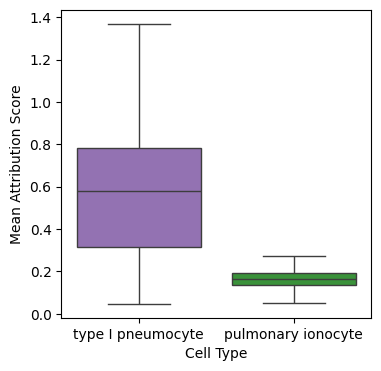

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(
    data=big_meta,
    x="prediction",
    y="AT1",
    showfliers=False,
    palette=["tab:purple", "tab:green"],
)
ax.set_ylabel("Mean Attribution Score")
ax.set_xlabel("Cell Type")

# MS1 Example

Replicate analysis in paper by calculating mean attributions for MS1 gene set and comparing across disease

## Collect Attributions and Calculate Scores

### Load SCimilarity Model and Attributions TileDB

In [11]:
# set use_gpu false when querying attributions
scim_model_path = "/home/scimilarity_model"  # Path to Scimilarity Model Downloaded from Zenodo (https://zenodo.org/records/15794176)
scim = SCimilarity(model_path=scim_model_path, use_gpu=False)

In [12]:
## this should be the folder where the attributions are stored
ct_base = "/home/celltype_attributions"  # Path to cell type attributions downloaded from Zenodo (https://zenodo.org/records/15794176)
all_ct = os.listdir(ct_base)

In [13]:
# analyze all monocyte/macrophage cell populations in database
ctoi = [
    "alveolar macrophage",
    "classical monocyte",
    "intermediate monocyte",
    "macrophage",
    "non-classical monocyte",
]

In [14]:
ms1_genes = ['S100A8', 'S100A12', 'RETN', 'CLU', 'MCEMP1', 'IL1R2', 'CYP1B1', 'SELL', 'ALOX5AP', 'SLC39A8', 'PLAC8', 'ACSL1', 'CD163', 'VCAN', 'HP', 'CTSD', 'LGALS1', 'THBS1', 'CES1', 'S100P', 'ANXA6', 'VNN2', 'NAMPT', 'HAMP', 'DYSF', 'SDF2L1', 'NFE2', 'SLC2A3', 'BASP1', 'ADGRG3', 'SOD2', 'CTSA', 'PADI4', 'CALR', 'SOCS3', 'NKG7', 'FLOT1', 'IL1RN', 'ZDHHC19', 'LILRA5', 'ASGR2', 'FAM65B', 'MNDA', 'STEAP4', 'NCF4', 'LBR', 'RP11-295G20.2', 'UBR4', 'PADI2', 'NCF1', 'LINC00482', 'RUNX1', 'RRP12', 'HSPA1A', 'FLOT2', 'ANPEP', 'CXCR1', 'ECE1', 'ADAM19', 'RP11-196G18.3', 'IL4R', 'DNAJB11', 'FES', 'MBOAT7', 'SNHG25', 'RP1-55C23.7', 'CPEB4', 'PRR34-AS1', 'HSPA1B', 'LINC01001', 'C1QC', 'SBNO2', 'GTSE1', 'FOLR3', 'STAB1', 'PLK1', 'HYI-AS1', 'LINC01281', 'TNNT1', 'AC097495.2', 'CTB-35F21.5', 'C19orf35', 'AC109826.1', 'RP11-800A3.7', 'LILRA6', 'PDLIM7', 'NPLOC4', 'C15orf48', 'APOBR', 'CSF2RB', 'CTD-2105E13.14', 'C1QB', 'RP11-123K3.9', 'IQGAP3', 'GAPLINC', 'CTC-490G23.2', 'JAK3', 'CTC-246B18.10', 'MYO5B']

### Check genes
Need to subset the genes of interest to ones that are included in the SCimilarity model

In [15]:
sig = SIGnature(gene_order=scim.gene_order, model=scim)
gene_list = sig.check_genes(ms1_genes)

The following genes are not included: RP11-196G18.3,AC097495.2,FAM65B,RP11-800A3.7,CTB-35F21.5,RP1-55C23.7,HYI-AS1,CTC-490G23.2,RP11-295G20.2,C19orf35,CTC-246B18.10,CTD-2105E13.14,RP11-123K3.9


In [16]:
len(gene_list)

86

### Calculate Mean Attribution Scores for each Cell Type

Iterate through tiledb of each cell type, calculate score, concatenate the metadata

In [17]:
score_name = "MS1"

In [18]:
meta_list = []
for ct in tqdm(ctoi):
    ## get specific tiledb path for location of interest
    ct_path = join(ct_base, ct)
    ## load attributions tiledb path for given cell type
    att_tdb_path = join(ct_path, "attributions")
    ## calculate
    results = sig.query_attributions(
        gene_list,
        return_aggregate=True,
        aggregate_type="mean",
        attribution_tiledb_uri=att_tdb_path,
    )

    ## example including weights
    # np.random.seed(114)
    # weight_list = np.random.choice([0.5, 1, 2], len(gene_list)).tolist()
    # results = sig.query_attributions(gene_list, return_aggregate=True, aggregate_type='mean', weights = weight_list, attribution_tiledb_uri=att_tdb_path)

    ## example getting individual genes
    # results = sig.query_attributions(gene_list, return_aggregate=False, attribution_tiledb_uri=att_tdb_path)

    ## load corresponding cell metadata
    ct_path = join(ct_base, ct)
    meta = pd.read_csv(join(ct_path, "cell_metadata.csv.gz"), index_col=0)

    ## put score
    meta[score_name] = results
    meta_list.append(meta.copy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.38s/it]


In [19]:
big_meta = pd.concat(meta_list)

In [20]:
big_meta.head(5)

,study,sample,prediction,fm_signature_score,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,prediction_nn_dist,data_type,...,ESC-derived,xenograft,tissue,cell_line_cleaned,disease,FACS_sort,sex_cleaned,author_label,celltype_index,MS1
298997,GSE160794,GSM4879379,alveolar macrophage,0.346716,3197,21991.0,959.0,4.360875,0.007285,unlabeled,...,False,False,lung,NaN,NaN,NaN,NaN,NaN,0,0.460732
298998,GSE160794,GSM4879379,alveolar macrophage,-0.290656,1167,3657.0,182.0,4.976757,0.011017,unlabeled,...,False,False,lung,NaN,NaN,NaN,NaN,NaN,1,0.703938
298999,GSE160794,GSM4879379,alveolar macrophage,0.695440,3515,21938.0,598.0,2.725864,0.021277,unlabeled,...,False,False,lung,NaN,NaN,NaN,NaN,NaN,2,0.433652
299001,GSE160794,GSM4879379,alveolar macrophage,-0.030102,2906,14594.0,729.0,4.995203,0.011253,unlabeled,...,False,False,lung,NaN,NaN,NaN,NaN,NaN,3,0.485425
299002,GSE160794,GSM4879379,alveolar macrophage,0.146310,3367,17256.0,536.0,3.106166,0.012170,unlabeled,...,False,False,lung,NaN,NaN,NaN,NaN,NaN,4,0.561418


### Analyze Scores

Load metadata into "Meta" object to perform gene signature analysis

#### Load and Filter Metadata

In [21]:
# Create a Meta object to manipulate the dataframe and perform standardized actions
momac_meta = Meta(big_meta)
# subset to high quality cells (SCimilarity prediction dist <0.02)
momac_meta.subset_hq()
# subset to only in vivo cells
momac_meta.subset_invivo()

In [22]:
ncell = momac_meta.df.shape[0]
nsamp = momac_meta.df["sample"].nunique()
nstudy = momac_meta.df["study"].nunique()
print(
    f"Analyzing {ncell} monocytes and macrophages from {nsamp} samples in {nstudy} studies"
)

Analyzing 2338447 monocytes and macrophages from 3443 samples in 244 studies


In [23]:
### Clarify some disease names for downstream figure
figure_disname_dict = {
    "atopic eczema": "Atopic Dermatitis",
    "COVID-19;healthy": "COVID-19 & Healthy (Mixed)",
    "Epstein-Barr virus infection;hemophagocytic syndrome": "EBV-Associated HLH",
    "Immune dysregulation-polyendocrinopathy-enteropathy-X-linked syndrome": "IPEX",
    "mucocutaneous lymph node syndrome": "Kawasaki Disease",
    "systemic scleroderma;interstitial lung disease": "SSC-ILD",
    "thrombocytopenia": "Severe Fever Thrombocytopenia Syndrome",
}

momac_meta.df["disease"] = [
    figure_disname_dict.get(x, x) for x in momac_meta.df["disease"]
]

#### Define "Hits" Based on Cutoff
Show multiple options for how to define hits and add to metadata (e.g. 90th percentile, 0.95 quantile, 2 stdev above mean)

In [24]:
hit_col = "MS1"
## 90th percentile
momac_meta.add_hits(
    column_name=hit_col,
    mode="percentile",
    cut_val=90,
    hit_type="above",
    string_append="__hit90p",
)

# # above 0.95 quantile
# momac_meta.add_hits(
#     column_name=hit_col,
#     mode="quantile",
#     cut_val=0.95,
#     hit_type="above",
#     string_append="__hit95p",
# )

# # above set value (2 stdev above mean)
# mean = np.mean(momac_meta[hit_col].values)
# std = np.std(momac_meta[hit_col].values)
# hit_val = mean + (2 * std)
# momac_meta.add_hits(
#     column_name=hit_col,
#     mode="value",
#     cut_val=hit_val,
#     hit_type="above",
#     string_append="__2zscore",
# )

#### Calculate hit percentage per sample
For all the monocytes/macrophages in each sample, calculate the percentage that are hits

Only consider samples with at least 25 monocytes/macrophages and diseases that have at least 3 samples

Then show the top 10 diseases by mean hit percentage

In [25]:
samphit_df_90 = momac_meta.samphit_df(
    cell_min=25, samp_min=3, hit_col="MS1__hit90p", num_dis=10
)

#### Generate sample boxplot (like figure 4a)

In [26]:
title = "MS1-like Cells in SCimilarity Database"

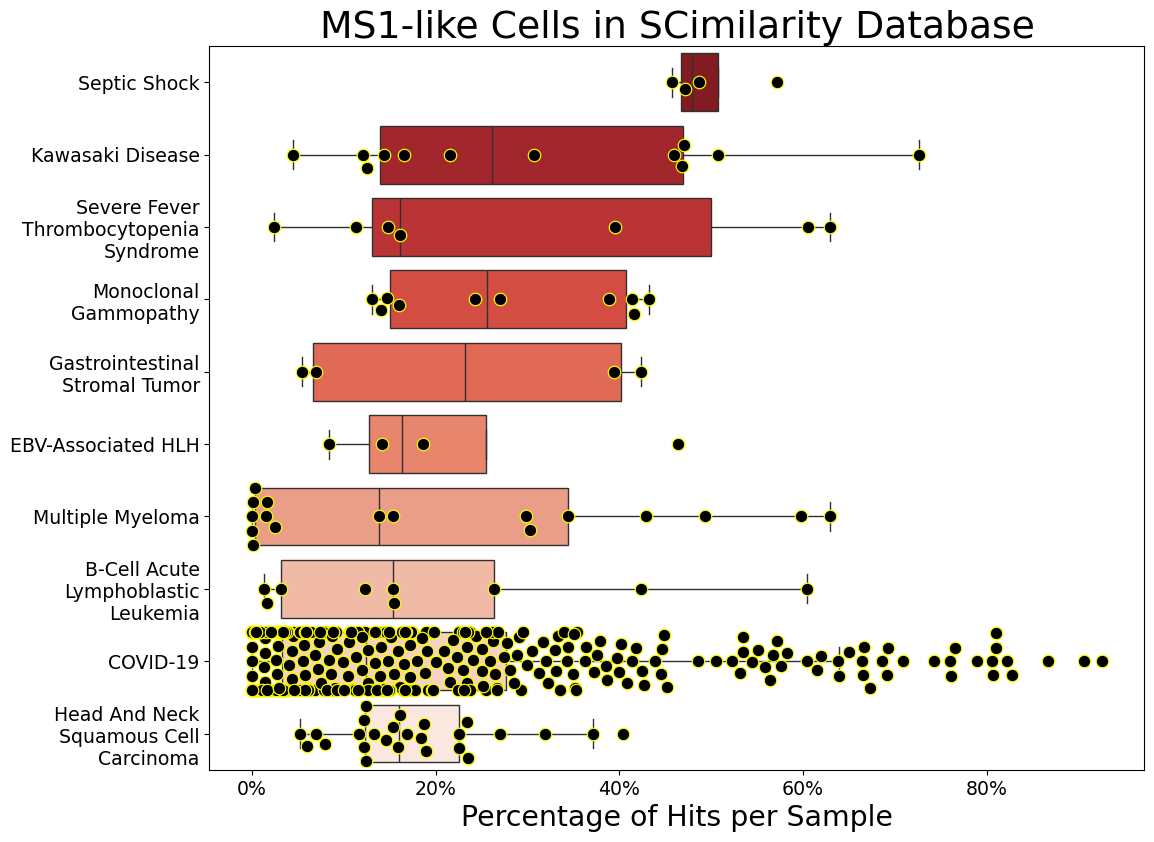

In [27]:
Meta.samphit_boxplot(
    samphit_df_90,
    hit_label="MS1__hit90p",
    swarm=True,
    figsize=(11.5, 8.5),
    fe=1.7,
    title=title,
    dotsize=9,
)